# W207 Baseline Submission
## Group 2: Austin Jin, Matt Lyons, Chandni Shah

<b> Project Link:</b> https://www.kaggle.com/c/petfinder-pawpularity-score

<b> Project Description:</b><br>
"In this competition, you’ll analyze raw images and metadata to predict the “Pawpularity” of pet photos. Your task is to predict engagement with a pet's profile based on the photograph for that profile. You are also provided with hand-labelled metadata for each photo. The dataset for this competition therefore comprises both images and tabular data." <br><br>

"Tabular Metadata: Each pet photo is labeled with the value of 1 (Yes) or 0 (No) for each of the following features. These labels are not used for deriving the Pawpularity score.

- Focus - Pet stands out against uncluttered background, not too close / far.
- Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.
- Face - Decently clear face, facing front or near-front.
- Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).
- Action - Pet in the middle of an action (e.g., jumping).
- Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.
- Group - More than 1 pet in the photo.
- Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).
- Human - Human in the photo.
- Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.
- Info - Custom-added text or labels (i.e. pet name, description).
- Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0."

## Part I - Metadata EDA

### In order to better understand the 'petfinder-pawpularity-score' dataset, we have performed some early EDA by performing the following pre-requisites:

## 1. Load in the packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
from matplotlib import image
from glob import glob
import cv2

%matplotlib inline

import time
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras import datasets, layers, models
from tqdm.auto import tqdm
from tensorflow.keras.applications import EfficientNetB0

import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
#source path (where the Pawpularity contest data resides)
path = './'

#Get the metadata (the .csv data) and put it into DataFrames
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

#Get the image data (the .jpg data) and put it into lists of filenames
train_jpg = glob(path + "train/*.jpg")
test_jpg = glob(path + "test/*.jpg")

In [3]:
# Printing the dimensions for the train metadata.
print('train_df dimensions: ', train_df.shape)
print('train_df column names: ', train_df.columns.values.tolist())

# Adding a space in between the dimensions for the train and test metadata
print('')

# Printing the dimensions for the test metadata
print('test_df dimensions: ',test_df.shape)
print('test_df column names: ', test_df.columns.values.tolist())

# After printing the shape of the train_df and test_df DataFrames, we have noticed that the train_df has 9912 rows and 14 columns whereas the test_df only has 8 rows and 13 columns. It is also worth mentioning that the test_df dataframe doesn't contain the pawpularity score.

train_df dimensions:  (9912, 14)
train_df column names:  ['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity']

test_df dimensions:  (8, 13)
test_df column names:  ['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']


### After printing the shape of the train_df and test_df dataframes, we can see that the train_df has 14 columns and 9912 rows, while the test_df only has 13 columns and 8 rows. It is also worth noting that the test_df particulary hasn't have pawpularity score data attached to it. We have further explored the metadata in the train dataframe since it would be the dataset for building out our models and have decided to utilize the test dataframe for practicing some predictions since it didn't contain a column for pawpularity score:

In [5]:
# Display the first 10 rows of the train_df dataframe
train_df.head(10)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74
6,0023b8a3abc93c712edd6120867deb53,0,1,1,1,0,0,0,0,1,1,0,0,22
7,0031d6a9ef7340f898c3e05f92c7bb04,0,1,1,0,0,0,1,1,0,0,1,0,35
8,0042bc5bada6d1cf8951f8f9f0d399fa,0,1,1,1,0,0,0,0,0,0,0,0,53
9,0049cb81313c94fa007286e9039af910,0,1,1,1,0,0,0,0,0,0,0,0,21


### It was noticed that train_df still contains ID's of the photos which means that we won't be necessarily using this metadata when building out the models. Since we figured that it would be useful to also take a look athe distribution of the target variable, which would be the Pawpularity Score in the ranges from 1-100, a simple histogram has been plotted out to view the distribution:

In [8]:
# Distribution for Pawpularity Scores

sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure()
sns.histplot(data=train_df, x='Pawpularity', bins=100)
plt.axvline(train_df['Pawpularity'].mean(), c='red', ls='-', lw=3, label='Mean Pawpularity')
plt.axvline(train_df['Pawpularity'].median(),c='blue',ls='-',lw=3, label='Median Pawpularity')
plt.title('Distribution of Pawpularity Scores', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

### After taking a look at the histogram, we see that there is a skew in the distribution of the pawpularity scores. It was interesting to see that there is a small curve close to zero Pawpularity along with another curve at the 100 Pawpularity Score with a count of close to 300. Since the EDA alone doesn't allow us to truly know the reason as to why there were many scores at 100, we have decided to keep the following theories in mind:

##### - Was there something unique about the animals such as their age, color, or breed that was most desirable by the people visiting the site?
##### - Did it have to do with the way in which photos were taken that were leading to more clicks and thus a higher Pawpularity score?
##### - Did it have to do with the Pawpularity score itself?
##### - Were there any outliers that need to be removed from the training data to improve the models that were built?
##### - Was there perhaps any noise in the dataset that caused the huge increase in pawpularity scores of 100?

### Since we are unable to find the actual answer through EDA alone, we plan on looking to develop concrete ML models that will allow us to see which features make more impact on the high pawpularity score in order to further explain the curves.

In [9]:
# Describe the distribution of the train dataframe in a numerical way

train_df[['Pawpularity']].describe()

In [10]:
# Put column names into a list
feature_variables = train_df.columns.values.tolist()

# For each feature variable, doesn't include Id and Pawpularity by using [1:-1]
# Display a boxplot and distribution plot against pawpularity
for variable in feature_variables[1:-1]:
    fig, ax = plt.subplots(1,2)
    sns.boxplot(data=train_df, x=variable, y='Pawpularity', ax=ax[0])
    sns.histplot(train_df, x="Pawpularity", hue=variable, kde=True, ax=ax[1])
    plt.suptitle(variable, fontsize=20, fontweight='bold')
    fig.show()

### As you can see from the charts, the distribution of pawpularity scores is very similar for each feature variable which means that changing the features doesn't end up influencing the pawpularity scores as much. This would mean that we would need to use the images and not the .csv metadata. This would've not been realized if it hadn't been for the EDA that was performed. We will focus on analyzing the pixels for the remainder of the baseline.

## Part II - Pixel EDA

### Before resizing the images to a uniform size, we have decided to explore the image data by taking a look at the first image in the train_jpg dataset and plotting that initial image:

In [11]:
print(train_jpg[0])

In [12]:
path_image = train_jpg[0]
array_image = plt.imread(path_image) 
print(array_image.shape)

plt.imshow(array_image)
plt.title('Initial Training Image') 
plt.axis('off')
plt.show()

### Next, we have attached a Pawpularity score as the title next to each image:

In [13]:
for x in range(3):
    path_image = train_jpg[x]
    array_image = plt.imread(path_image) 
    print("The image {}'s dimensions are: {}".format(x,array_image.shape))
    plt.imshow(array_image)
    plt.title(x) 
    plt.axis('off')
    plt.show()

### After gaining an initial sense of images looked, we have decided to start resizing the images to a uniform size. In this transformation, we also add white padding to images to help preserve image quality during the resizing.

In [4]:
## Process in the training and test data, including the bw 1-d train data for baseline

train_path = './train_resized'
train_bw_path = './train_resized_bw'
test_path = './test'

train_jpg = glob(train_path + "/*.jpg")
train_bw_jpg = glob(train_bw_path + "/*.jpg")
test_jpg = glob(test_path + "/*.jpg")


train_images = [cv2.imread(file) for file in train_jpg]
train_bw_images_1d = [cv2.imread(file, 0).flatten(order = 'C') for file in train_bw_jpg] # 0 for grayscale, C for row-style flattening
test_images = [cv2.imread(file) for file in test_jpg]

In [5]:
# normalize pixel values from 0 to 1 instead of from 0 to 255.
X = np.array(train_bw_images_1d)
X = X / 255
Y = np.array(train_df['Pawpularity'])

In [23]:
X.shape

### Examples of Transformed Images, Top Scoring Images, and Bottom Scoring Images:

In [21]:
#examples of transformed images
pltnum = 0
plt.figure(figsize=(100,100))

for i in range(3):
    pltnum += 1
    plt.subplot(1, 3, pltnum)
    plt.imshow(X[i].reshape(300,300), cmap='gray')
    plt.axis('off')

In [ ]:
#examples of score = 100

y_100 = np.where(Y == 100)


pltnum = 0
plt.figure(figsize=(100,100))

for i in y_100[0][:3]:
    pltnum += 1
    plt.subplot(1, 3, pltnum)
    plt.imshow(X[i].reshape(300,300), cmap='gray')
    plt.axis('off')

In [ ]:
#example of scores in 75th percentile
y_75quant = np.where(Y == np.percentile(Y, 75))

pltnum = 0
plt.figure(figsize=(100,100))

for i in y_75quant[0][:3]:
    pltnum += 1
    plt.subplot(1, 3, pltnum)
    plt.imshow(X[i].reshape(300,300), cmap='gray')
    plt.axis('off')

In [ ]:
#example of scores in 25th percentile
y_25quant = np.where(Y == np.percentile(Y, 25))

pltnum = 0
plt.figure(figsize=(100,100))

for i in y_25quant[0][:3]:
    pltnum += 1
    plt.subplot(1, 3, pltnum)
    plt.imshow(X[i].reshape(300,300), cmap='gray')
    plt.axis('off')

### Part III - Baseline Model with Tabular Data

### While we will be scoring on RMSE, we also created a custom scoring function to determine if the pawpularity predicted scores are within a specific point-range of the actual scores.

In [6]:
def proximity_score(predicted, actual, tol=5):
    size = 1
    for dim in np.shape(actual): size *= dim
    return np.count_nonzero(np.absolute(np.subtract(predicted, actual)) <= tol) / size

### KNN Regression Model (tabular data)

In [13]:
# select tabular columns
X2 = np.array(train_df)[:,1:13]

train_array, test_array, train_labels, test_labels = train_test_split(X2, Y, test_size = .2, random_state = 42)
print(train_array.shape)
print(train_labels.shape)
print(test_array.shape)
print(test_labels.shape)

(7929, 12)
(7929,)
(1983, 12)
(1983,)


In [14]:
tol = 10

def KNN(k_values):
    for val in k_values:
        KNN_model = KNeighborsRegressor(n_neighbors=val)
        KNN_model.fit(train_array, train_labels)
        test_predict = KNN_model.predict(test_array)
        print("For k = ", val, ", the RMSE is: ", round(sqrt(mean_squared_error(test_labels, test_predict)),4), ".", sep="")
        print("For k =", val, ",", "{:.2%}".format(proximity_score(test_labels, test_predict, tol)),
              "of predicted labels are within", tol, "of the correct label.","\n")
        
k_values = [1, 5, 9, 11, 55, 175, 201, 301, 501]
KNN(k_values)

For k = 1, the RMSE is: 35.4794.
For k = 1 , 24.36% of predicted labels are within 10 of the correct label. 

For k = 5, the RMSE is: 24.0034.
For k = 5 , 40.44% of predicted labels are within 10 of the correct label. 

For k = 9, the RMSE is: 24.7551.
For k = 9 , 36.21% of predicted labels are within 10 of the correct label. 

For k = 11, the RMSE is: 24.0742.
For k = 11 , 39.84% of predicted labels are within 10 of the correct label. 

For k = 55, the RMSE is: 21.4419.
For k = 55 , 45.69% of predicted labels are within 10 of the correct label. 

For k = 175, the RMSE is: 21.0262.
For k = 175 , 43.47% of predicted labels are within 10 of the correct label. 

For k = 201, the RMSE is: 20.9892.
For k = 201 , 42.76% of predicted labels are within 10 of the correct label. 

For k = 301, the RMSE is: 21.0011.
For k = 301 , 41.75% of predicted labels are within 10 of the correct label. 

For k = 501, the RMSE is: 21.027.
For k = 501 , 42.76% of predicted labels are within 10 of the correct 

### We have thought about different ways to handle the many values at 100, but one way would be to ignore them during training. We will see whether that gives us a more accurate value here.

In [52]:
train_df_culled = train_df[train_df['Pawpularity'] != 100]
Y = np.array(train_df_culled['Pawpularity'])
X3 = np.array(train_df_culled)[:,1:13]

train_array, test_array, train_labels, test_labels = train_test_split(X3, Y, test_size = .2, random_state = 7)

tol = 10

def KNN(k_values):
    for val in k_values:
        KNN_model = KNeighborsRegressor(n_neighbors=val)
        KNN_model.fit(train_array, train_labels)
        test_predict = KNN_model.predict(test_array)
        print("For k = ", val, ", the RMSE is: ", round(sqrt(mean_squared_error(test_labels, test_predict)),4), ".", sep="")
        print("For k =", val, ",", "{:.2%}".format(proximity_score(test_labels, test_predict, tol)),
              "of predicted labels are within", tol, "of the correct label.","\n")
        
k_values = [1, 5, 9, 11, 55, 175, 201, 301, 501]
KNN(k_values)

For k = 1, the RMSE is: 26.2623.
For k = 1 , 34.65% of predicted labels are within 10 of the correct label. 

For k = 5, the RMSE is: 19.8338.
For k = 5 , 47.22% of predicted labels are within 10 of the correct label. 

For k = 9, the RMSE is: 18.1988.
For k = 9 , 44.10% of predicted labels are within 10 of the correct label. 

For k = 11, the RMSE is: 18.1796.
For k = 11 , 44.88% of predicted labels are within 10 of the correct label. 

For k = 55, the RMSE is: 17.9063.
For k = 55 , 43.69% of predicted labels are within 10 of the correct label. 

For k = 175, the RMSE is: 17.8739.
For k = 175 , 46.39% of predicted labels are within 10 of the correct label. 

For k = 201, the RMSE is: 17.8831.
For k = 201 , 45.71% of predicted labels are within 10 of the correct label. 

For k = 301, the RMSE is: 17.8574.
For k = 301 , 45.92% of predicted labels are within 10 of the correct label. 

For k = 501, the RMSE is: 17.8544.
For k = 501 , 47.17% of predicted labels are within 10 of the correct

### Indeed, omitting the 100s yielded better performance, therefore we will continue to do so.

### Linear Regression Model (tabular data)

In [25]:
lr_model = LinearRegression()
lr_model.fit(train_array, train_labels)
lr_model.intercept_, lr_model.coef_

(35.75923615569606,
 array([ 0.30661837, -1.89271815,  1.82476792,  0.10657321,  1.40827163,
         1.22205893,  1.60987839,  0.0287796 ,  0.25298117,  0.22067164,
         0.29551496, -2.76479873]))

In [26]:
lr_model.score(test_array, test_labels)

0.002934269953138169

In [27]:
lr_predict_tab = lr_model.predict(test_array)
print("LR RMSE is: ", round(sqrt(mean_squared_error(test_labels, lr_predict_tab)), 4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, lr_predict_tab, tol)), 
      " of the LR-predicted labels were within", tol, "of the correct label.")

LR RMSE is: 17.8485.
47.27%  of the LR-predicted labels were within 10 of the correct label.


### Despite what we anticipated to be poor predictive power of the tabular data, they performed, though not amazingly well, not horribly, and in fact outperformed the image data using linear regression (those models will be presented next).

### Decision Trees (Tabular Data)

In [53]:
#create the Regressor
tree_reg = DecisionTreeRegressor(max_depth = 3, min_samples_split = 10)

#train the model and predict labels
tree_reg.fit(train_array, train_labels)
tree_reg_pred = tree_reg.predict(test_array)

#print the RMSE and Proximity Scores
tree_reg_RMSE = sqrt(mean_squared_error(test_labels, tree_reg_pred))
print("Decision Tree RMSE is: ", round(tree_reg_RMSE,4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, tree_reg_pred, tol)),
              "of predicted labels are within", tol, "of the correct label.","\n")

Decision Tree RMSE is: 17.9232.
46.55% of predicted labels are within 10 of the correct label. 



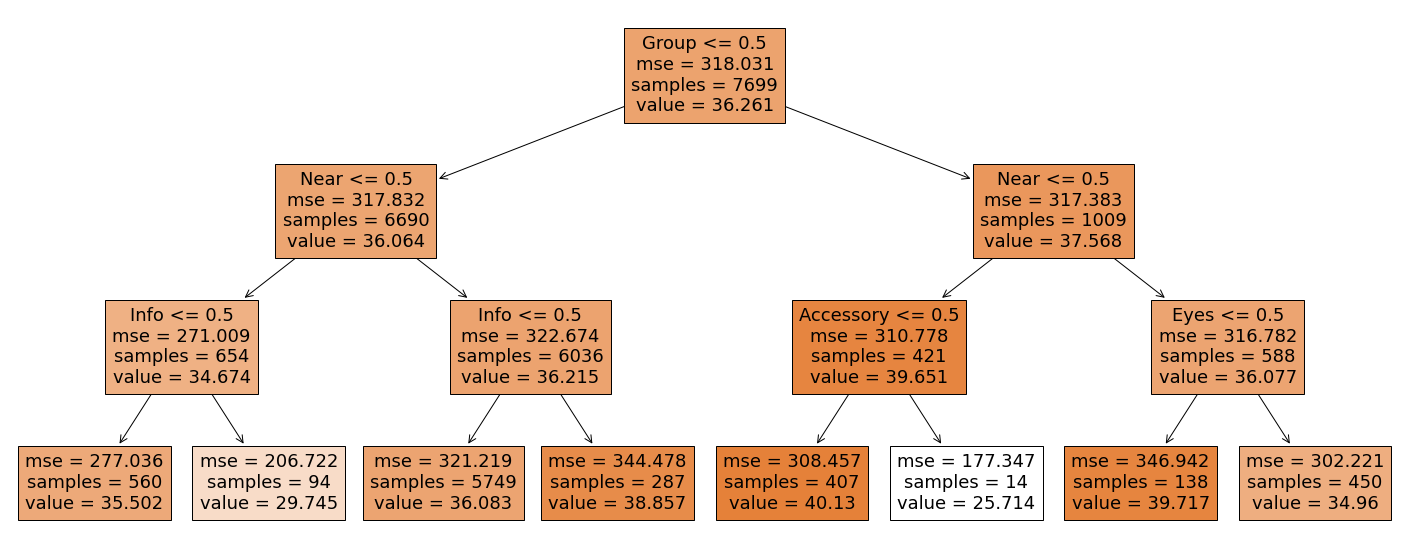

In [54]:
#visualize the decision tree
fig = plt.figure(figsize=(25,10))
plot = tree.plot_tree(tree_reg, feature_names=train_df.columns.values.tolist()[1:13], filled=True)

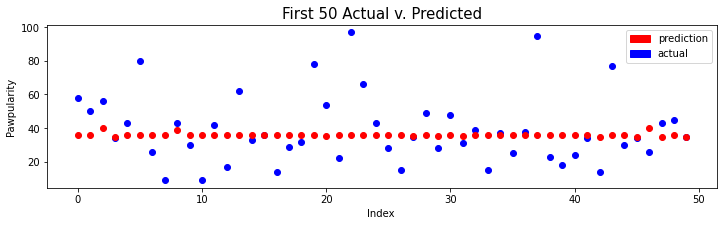

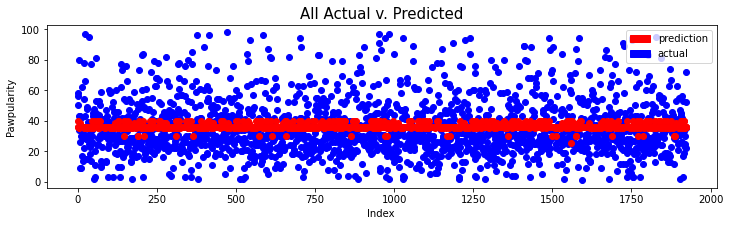

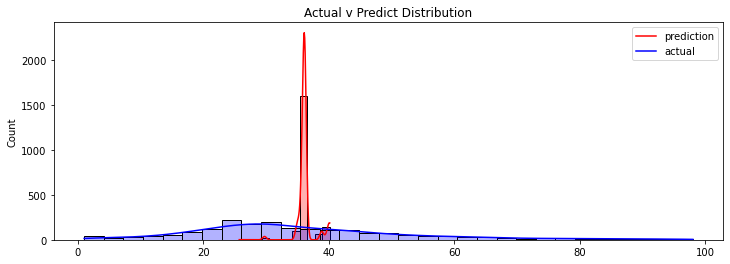

In [55]:
#let's see what our predictions look like vs the actual 
def ActualvPredictionsGraph(test_labels,y_pred,title):
    if max(test_labels) >= max(y_pred):
        my_range = int(max(test_labels))
    else:
        my_range = int(max(y_pred))
    plt.figure(figsize=(12,3))
    plt.scatter(range(len(test_labels)), test_labels, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.xlabel('Index ')
    plt.ylabel('Pawpularity ')
    plt.title(title,fontdict = {'fontsize' : 15})
    plt.legend(handles = [mpatches.Patch(color='red', label='prediction'),mpatches.Patch(color='blue', label='actual')])
    plt.show()
    return

#plot it
ActualvPredictionsGraph(test_labels[0:50], tree_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(test_labels, tree_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(tree_reg_pred,color='r',alpha=0.3,stat='count', kde=True)
sns.histplot(test_labels,color='b',alpha=0.3,stat='count', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

### We observe our predictions are guessing near the mean, which doesn't align with the true shape of the scores distribution.

### Random Forest (Tabular Data)

### We will explore if a random forest ensemble of 100 trees will help improve our model performance:

In [56]:
#create the Random Forest ensemble
RF_reg = RandomForestRegressor(n_estimators=100, max_depth=3)

#train the model and predict labels
RF_reg.fit(train_array, train_labels)
RF_reg_pred = RF_reg.predict(test_array)

#Print the RMSE and Proximity Scores
RF_reg_RMSE = sqrt(mean_squared_error(test_labels, RF_reg_pred))
print("Random Forest RMSE is: ", round(RF_reg_RMSE,4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, RF_reg_pred, tol)),
              "of predicted labels are within", tol, "of the correct label.","\n")

Random Forest RMSE is: 17.8531.
46.81% of predicted labels are within 10 of the correct label. 



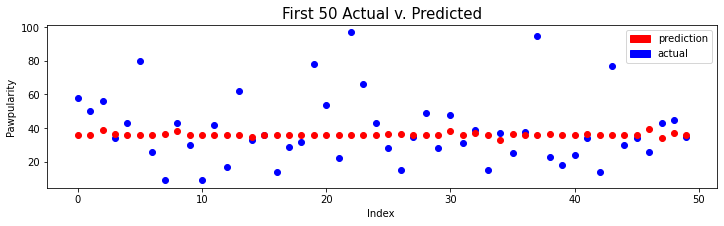

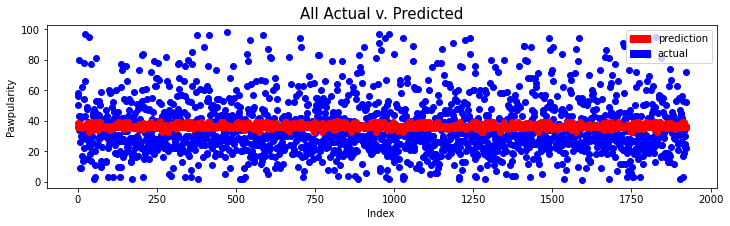

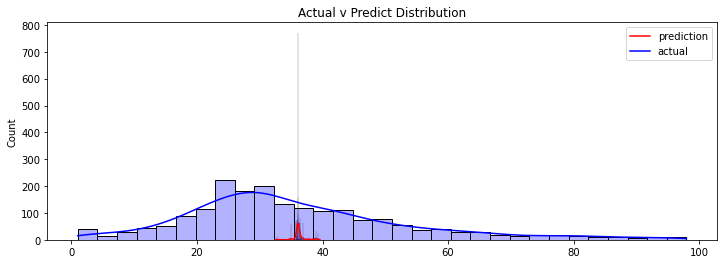

In [57]:
#plot it
ActualvPredictionsGraph(test_labels[0:50], RF_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(test_labels, RF_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(RF_reg_pred,color='r',alpha=0.3,stat='count',kde=True)
sns.histplot(test_labels,color='b',alpha=0.3,stat='count', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

### Using a random forest ensemble of decision trees does not largely improve our model. The model is still predicting near the mean and the distribution of scores still does not align.

### We have tested KNN Regression, Linear Regression, Decision Tree Regression, and a Random Forest Ensemble on the tabular data. Of the tested models, the Random Forest Ensemble has produced the lowest RMSE score. We will move on to explore the image pixel data separately.

### Part IV - Baseline Model with Image Pixel Data

### Earlier, we loaded in all of the images, but we need to now exclude the outliers (Pawpularity = 100) as we did above.

In [39]:
## Process in the training and test data, including the bw 1-d train data for baseline

train = pd.read_csv('./train.csv')
train = train[train['Pawpularity'] != 100]
test = pd.read_csv('./test.csv')

def get_train_file_path(image_id):
    return "./train_resized/{}.jpg".format(image_id)

def get_train_bw_file_path(image_id):
    return "./train_resized_bw/{}.jpg".format(image_id)

def get_test_file_path(image_id):
    return "./test/{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_file_path)
train['file_path_bw'] = train['Id'].apply(get_train_bw_file_path)
test['file_path'] = test['Id'].apply(get_test_file_path)

train_images = [cv2.imread(file) for file in train['file_path']]
train_bw_images_1d = [cv2.imread(file, 0).flatten(order = 'C') for file in train['file_path_bw']] # 0 for grayscale, C for row-style flattening
test_images = [cv2.imread(file) for file in test['file_path']]

In [42]:
# split our new culled image data identically as before
X4 = np.array(train_bw_images_1d)
X4 = X / 255
Y = np.array(train_df_culled['Pawpularity'])

train_images, test_array, train_labels, test_labels = train_test_split(X4, Y, test_size = .2, random_state = 7)
train_bw_images_1d, test_array, train_labels, test_labels = train_test_split(X4, Y, test_size = .2, random_state = 7)

print(len(train_images))
print(len(train_bw_images_1d))
print(train_labels.shape)
print(test_array.shape)
print(test_labels.shape)

7699
7699
(7699,)
(1925, 90000)
(1925,)


### KNN Regression Model (grayscale image pixel data)

In [44]:
tol = 10

def KNN(k_values):
    for val in k_values:
        KNN_model = KNeighborsRegressor(n_neighbors=val)
        KNN_model.fit(train_bw_images_1d, train_labels)
        test_predict = KNN_model.predict(test_array)
        print("For k = ", val, ", the RMSE is: ", round(sqrt(mean_squared_error(test_labels, test_predict)),4), ".", sep="")
        print("For k =", val, ",", "{:.2%}".format(proximity_score(test_labels, test_predict, tol)),
              "of predicted labels are within", tol, "of the correct label.","\n")
        
k_values = [1, 5, 9, 11, 55, 175, 201, 301, 501]
KNN(k_values)

For k = 1, the RMSE is: 25.4409.
For k = 1 , 37.77% of predicted labels are within 10 of the correct label. 

For k = 5, the RMSE is: 19.7311.
For k = 5 , 42.34% of predicted labels are within 10 of the correct label. 

For k = 9, the RMSE is: 18.7708.
For k = 9 , 44.26% of predicted labels are within 10 of the correct label. 

For k = 11, the RMSE is: 18.6631.
For k = 11 , 44.42% of predicted labels are within 10 of the correct label. 

For k = 55, the RMSE is: 17.9159.
For k = 55 , 47.69% of predicted labels are within 10 of the correct label. 

For k = 175, the RMSE is: 17.8637.
For k = 175 , 47.69% of predicted labels are within 10 of the correct label. 

For k = 201, the RMSE is: 17.8642.
For k = 201 , 47.58% of predicted labels are within 10 of the correct label. 

For k = 301, the RMSE is: 17.889.
For k = 301 , 47.69% of predicted labels are within 10 of the correct label. 

For k = 501, the RMSE is: 17.8716.
For k = 501 , 47.79% of predicted labels are within 10 of the correct 

### We observe the KNN regression produces results roughly consistent with the tabular data, with best results around k=175.

### Linear Regression Model (grayscale image pixel data)

In [45]:
lr_model = LinearRegression()
lr_model.fit(train_bw_images_1d, train_labels)
lr_model.intercept_, lr_model.coef_

(32.778541463538915,
 array([-52.64005577, -76.73807322, -57.87729478, ...,  80.8790253 ,
        121.75087479, 121.10937129]))

In [47]:
lr_model.score(test_array, test_labels)

-1.2914734067775089

In [49]:
lr_predict = lr_model.predict(test_array)
print("LR RMSE is: ", round(sqrt(mean_squared_error(test_labels, lr_predict)), 4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, lr_predict, tol)), 
      " of the LR-predicted labels were within", tol, "of the correct label.")

LR RMSE is: 27.0581.
28.83%  of the LR-predicted labels were within 10 of the correct label.


### For the pixel data, we can observe the linear regression model performs poorly compared to the KNN models. We achieve an RMSE score of 27.0581, much higher than any of the KNN models. Separately, we achieve a negative R squared score, which means the model's best-fit line fits worse than a horizontal line.

### We tried combining the tabular and image data, but a naive average performed worse than the better of the two. In a way, this seems promising, because it shows they are performing better in distinct ways! We will look at more sophisticated ways to combine them as we move forward.

### Based on these results, we will move forward with the KNN Regression with our baseline model using pixel data. The RMSE for our baseline model is 17.8637.

### We will now be building a CNN model, which we hope will be able to better handle the complexity of the images and, in return, lower the RMSE.

### Decision Tree Models were explored after establishing the baseline. The Random Forest Ensemble seems to outperform any model so far with a RMSE of 17.8531. While this is the lowest RMSE achieved, the model is still relying heavily on the score mean to make predictions. We will explore if a CNN Model is better able to predict scores without this reliance on the mean. It's possible that outside noise is driving the pet image clicks, and therefore scores, rather than pixel data or tabular data.

### CNN Pre-Processing

In [58]:
# Re-modifying the Id such that each Id is the full image path
def train_id_to_path(x):
    return './train/' + x + ".jpg"
def test_id_to_path(x):
    return './test/' + x + ".jpg"

In [59]:
# Re-reading in the data and drop unnecessary columns
train = pd.read_csv('./train.csv')
train = train[train['Pawpularity'] != 100].reset_index()
train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

In [60]:
# Adding the .jpg extensions to the image file name ids
train["img_path"] = train["Id"].apply(train_id_to_path)
test["img_path"] = test["Id"].apply(test_id_to_path)

In [61]:
# Set the size image (constraining to square)
image_dim = 128

# Define a function that accepts an image url and outputs an eager tensor
def path_to_eagertensor(image_path, image_dim):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (image_dim, image_dim))
    return image

In [62]:
# Obtain all images in the training folder and put their tensors in a list
def build_tensor_list(image_dim):
    X = []
    for img in tqdm(train['img_path']):
        new_img_tensor = path_to_eagertensor(img, image_dim)
        X.append(new_img_tensor)
    X = np.array(X)
    return X
    
X = build_tensor_list(image_dim)
    
print(type(X),X.shape)

  0%|          | 0/9624 [00:00<?, ?it/s]

<class 'numpy.ndarray'> (9624, 128, 128, 3)


In [63]:
# Setting our train target y to be the Pawpularity score
Y = train['Pawpularity']

In [64]:
# divide into train/dev/test sets

train_array, rem_array, train_labels, rem_labels = train_test_split(X, Y, train_size = .8, random_state = 7)
dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)

print("Training shape:", (train_array.shape), (train_labels.shape))
print("Dev shape:", (dev_array.shape), (dev_labels.shape))
print("Test shape:", (test_array.shape), (test_labels.shape))

Training shape: (7699, 128, 128, 3) (7699,)
Dev shape: (962, 128, 128, 3) (962,)
Test shape: (963, 128, 128, 3) (963,)


### CNN Model

In [30]:
def get_model(SEED=7):
    tf.keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    input_ = keras.Input(shape=(X.shape[1],X.shape[2],3))

    x = keras.layers.Conv2D(filters = 16, kernel_size=7, strides=2, padding='valid', kernel_initializer='he_normal',
                           kernel_regularizer=l2(0.0005), activation = 'relu')(input_)

    x = keras.layers.Conv2D(filters = 32, kernel_size=3, padding='same', kernel_initializer='he_normal',
                           activation = 'relu')(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2D(filters = 32, kernel_size=3,strides=2, padding='same', kernel_initializer='he_normal',
                           activation = 'relu', kernel_regularizer=l2(0.0005))(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.Conv2D(filters = 64, kernel_size=3, padding='same', kernel_initializer='he_normal', activation='relu'
                            ,kernel_regularizer=l2(0.0002))(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 2, padding='same',
                               kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(0.25)(x)

    #####
    x = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(filters = 128, kernel_size = 3,padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(512, activation = "relu")(x)

    x = keras.layers.Dropout(0.5)(x)

    output = keras.layers.Dense(1)(x)

    model = keras.Model(inputs = input_, outputs = output)
    
    return model

In [31]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 16)        2368      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0     

In [14]:
#compile the model
model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [15]:
data_augmentation = ImageDataGenerator(rotation_range=40, zoom_range=0.3, width_shift_range = 0.3, 
    height_shift_range = 0.3, 
    shear_range = 0.3,
    horizontal_flip = True, 
    fill_mode = "nearest")

In [16]:
kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)

history = model.fit(
    data_augmentation.flow(train_array,train_labels,batch_size=128),
    validation_data = (test_array,test_labels),
    steps_per_epoch = len(train_array) // 1024,
    epochs = 600, callbacks=[kall]
)

Epoch 1/600
7/7 [==============================] - 5s 268ms/step - loss: 856.8936 - rmse: 29.2686 - val_loss: 1953.3464 - val_rmse: 44.1940
Epoch 2/600
7/7 [==============================] - 2s 264ms/step - loss: 491.9645 - rmse: 22.1748 - val_loss: 1220.8478 - val_rmse: 34.9372
Epoch 3/600
7/7 [==============================] - 2s 261ms/step - loss: 544.1297 - rmse: 23.3214 - val_loss: 1415.3662 - val_rmse: 37.6181
Epoch 4/600
7/7 [==============================] - 2s 260ms/step - loss: 521.8589 - rmse: 22.8389 - val_loss: 1376.0470 - val_rmse: 37.0918
Epoch 5/600
7/7 [==============================] - 2s 260ms/step - loss: 475.1339 - rmse: 21.7920 - val_loss: 1276.6667 - val_rmse: 35.7271
Epoch 6/600
7/7 [==============================] - 2s 265ms/step - loss: 454.4641 - rmse: 21.3125 - val_loss: 773.3924 - val_rmse: 27.8056
Epoch 7/600
7/7 [==============================] - 2s 264ms/step - loss: 491.4781 - rmse: 22.1638 - val_loss: 885.9481 - val_rmse: 29.7608
Epoch 8/600
7/7 [=====

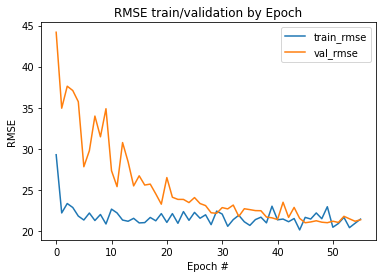

In [17]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right");

In [142]:
# Predict on the submission data
cnn_pred = model.predict(X_submission)
print(X_submission.shape, type(X_submission))
print(cnn_pred.shape, type(cnn_pred))

(8, 256, 256, 3) <class 'numpy.ndarray'>
(8, 1) <class 'numpy.ndarray'>


### So our first-draft model works, though not significantly better than previous attempts. In order to improve performance, we will work on tuning hyperparameters. In this case, these fall into several categories: input image size, model parameters (dropout, layer structure, number of filters, kernel size), and augmentation settings (rotation range, zoom range, width/height shift range).

### Because the number of filters and kernel size are not independent from the image size, these will be tuned with many combinations. However, augmentation settings should be largely independent and will be tuned separately.

### First, we will set up helper functions to make things easier/more readable. Then we will iterate through hyperparameters to improve the model's performance. (Quick note: even with pre-set random states, the training can occasionally result in different values than were previously obtained, so the markup cells will contain the best result from when we ran this, but they won't necessarily be the best in your run, especially if they are close).

In [65]:
# Define a function that accepts an image url and outputs an eager tensor
def path_to_eagertensor(image_path, image_dim, pad):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    if pad == 1:
        image = tf.image.resize_with_pad(image, image_dim, image_dim)
    else:
        image = tf.image.resize(image, (image_dim, image_dim))
    return image

def build_tensor_list(image_dim, pad):
    X = []
    for img in tqdm(train['img_path']):
        new_img_tensor = path_to_eagertensor(img, image_dim, pad)
        X.append(new_img_tensor)
    X = np.array(X)
    return X

def configure_datasets(image_dim, pad=0): 
    X = build_tensor_list(image_dim, pad)
    Y = train['Pawpularity']
    train_array, rem_array, train_labels, rem_labels = train_test_split(X, Y, train_size = .8, random_state = 7)
    dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)
    return X, Y, train_array, train_labels, test_array, test_labels, dev_array, dev_labels
    
def get_model(SEED=7, mid_drop=0.25, n_filter_factor=16, kernel_size_factor=32, layer_sets=4, image_dim=128, dense=512):
    tf.keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    n_filters = image_dim/(n_filter_factor)
    k_l = int(round(image_dim/(kernel_size_factor), 0)) # (kernel "large")
    k_s = max(int(round(k_l/2, 0)),1) # (kernel "small")
    
    input_ = keras.Input(shape=(X.shape[1],X.shape[2],3))

    x = keras.layers.Conv2D(filters = n_filters, kernel_size=k_l, strides=[2,2], padding='valid', kernel_initializer='he_normal',
                           kernel_regularizer=l2(0.0005), activation = 'relu')(input_)
    x = keras.layers.Conv2D(filters = 2*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal',
                           activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters = 2*n_filters, kernel_size=k_s,strides=[2,2], padding='same', kernel_initializer='he_normal',
                           activation = 'relu', kernel_regularizer=l2(0.0005))(x)
    x = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.Dropout(mid_drop)(x)
    
    x = keras.layers.Conv2D(filters = 4*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal', 
                            activation='relu', kernel_regularizer=l2(0.0002))(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2D(filters = 4*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal', 
                            activation='relu', kernel_regularizer=l2(0.0002))(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(mid_drop)(x)

    x = keras.layers.Conv2D(filters = 8*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal', 
                            activation='relu', kernel_regularizer=l2(0.0002))(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.MaxPooling2D(pool_size=k_s)(x)

    x = keras.layers.Conv2D(filters = 8*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal', 
                            activation='relu', kernel_regularizer=l2(0.0002))(x)
        
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(mid_drop)(x)

    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(dense, activation = "relu")(x)

    x = keras.layers.Dropout(2*mid_drop)(x)

    output = keras.layers.Dense(1)(x)
    model = keras.Model(inputs = input_, outputs = output)
    
    return model

### We will first test whether resizing or padding performs better.

In [76]:
for pad in [0,1]:
    print("="*60)
    print("Now testing padding. Resizing images for the model...", sep="")
    image_dim = 128
    X, Y, train_array, train_labels, test_array, test_labels, dev_array, dev_labels = configure_datasets(image_dim=image_dim, pad=pad)
    model = get_model(mid_drop=0.25, n_filter_factor=8, kernel_size_factor=16, layer_sets=4, image_dim=image_dim, dense=512)
    model.compile(
        loss = 'mse', 
        optimizer = 'Adam', 
        metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
    print("Done resizing. Now fitting model (verbose output deactivated, please be patient).")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=512),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 512,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For pad =",pad,"best score is",min(current_model.history["val_rmse"]))

Now testing padding. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For pad = 0 best score is 22.715497970581055
Now testing padding. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For pad = 1 best score is 22.27263069152832


### Padding appears to slightly outperform resizing. 

In [81]:
pad = 1

for image_dim in [20,25,30,40,50,80,100,140,180,240]:
    print("="*60)
    print("Now testing image size ", image_dim,"x",image_dim,". Resizing images for the model...", sep="")
    X, Y, train_array, train_labels, test_array, test_labels, dev_array, dev_labels = configure_datasets(image_dim=image_dim, pad=pad)
    model = get_model(mid_drop=0.25, n_filter_factor=8, kernel_size_factor=16, layer_sets=4, image_dim=image_dim)
    model.compile(
        loss = 'mse', 
        optimizer = 'Adam', 
        metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
    print("Done resizing. Now fitting model (verbose output deactivated, please be patient).")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=128),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 128,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For image dim = ",image_dim,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Now testing image size 20x20. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 20, best score is: 20.998106002807617.
Now testing image size 25x25. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 25, best score is: 20.870811462402344.
Now testing image size 30x30. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 30, best score is: 21.08254051208496.
Now testing image size 40x40. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 40, best score is: 20.801183700561523.
Now testing image size 50x50. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 50, best score is: 20.894989013671875.
Now testing image size 80x80. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 80, best score is: 24.306787490844727.
Now testing image size 100x100. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 100, best score is: 21.167146682739258.
Now testing image size 140x140. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 140, best score is: 20.799436569213867.
Now testing image size 180x180. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 180, best score is: 21.179229736328125.
Now testing image size 240x240. Resizing images for the model...


  0%|          | 0/9912 [00:00<?, ?it/s]

Done resizing. Now fitting model (verbose output deactivated, please be patient).
For image dim = 240, best score is: 20.904590606689453.


### It's VERY close, but we are seeing the best performance around image size 140x140, so we will use that going forward.

In [71]:
pad = 1
image_dim = 140

X, Y, train_array, train_labels, test_array, test_labels, dev_array, dev_labels = configure_datasets(image_dim=image_dim, pad=pad)
model = get_model(mid_drop=0.25, n_filter_factor=8, kernel_size_factor=16, layer_sets=4, image_dim=image_dim)
model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)

for rotation_range in [10,20,30,40,45,50]:
    print("="*60)
    print("Now testing rotation range ", rotation_range, sep="")
    print("Now fitting model (verbose output deactivated, please be patient).")
    data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=0.3, width_shift_range = 0.3, 
                                            height_shift_range = 0.3, 
                                            shear_range = 0.3,
                                            horizontal_flip = True, 
                                            fill_mode = "nearest")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=128),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 128,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For rotation range = ",rotation_range,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

  0%|          | 0/9624 [00:00<?, ?it/s]

Now testing rotation range 10
Now fitting model (verbose output deactivated, please be patient).
For rotation range = 10, best score is: 21.400875091552734.
Now testing rotation range 20
Now fitting model (verbose output deactivated, please be patient).
For rotation range = 20, best score is: 19.595762252807617.
Now testing rotation range 30
Now fitting model (verbose output deactivated, please be patient).
For rotation range = 30, best score is: 19.28080177307129.
Now testing rotation range 40
Now fitting model (verbose output deactivated, please be patient).
For rotation range = 40, best score is: 19.1013126373291.
Now testing rotation range 45
Now fitting model (verbose output deactivated, please be patient).
For rotation range = 45, best score is: 18.960296630859375.
Now testing rotation range 50
Now fitting model (verbose output deactivated, please be patient).
For rotation range = 50, best score is: 19.008028030395508.


### Best rotation range: 45

In [8]:
pad = 1
image_dim = 140
rotation_range = 45
current_param = "zoom range"

for zoom_range in [0.1,0.3,0.5,0.7,0.9]:
    print("="*60)
    print("Now testing ",current_param," ",zoom_range, sep="")
    print("Now fitting model (verbose output deactivated, please be patient).")
    data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = 0.3, 
                                            height_shift_range = 0.3, 
                                            shear_range = 0.3,
                                            horizontal_flip = True, 
                                            fill_mode = "nearest")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=128),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 128,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For ",current_param," ",zoom_range,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Now testing Zoom range 0.1
Now fitting model (verbose output deactivated, please be patient).
For  = Zoom range 0.1, best score is: 21.193647384643555.
Now testing Zoom range 0.3
Now fitting model (verbose output deactivated, please be patient).
For  = Zoom range 0.3, best score is: 21.359281539916992.
Now testing Zoom range 0.5
Now fitting model (verbose output deactivated, please be patient).
For  = Zoom range 0.5, best score is: 21.094894409179688.
Now testing Zoom range 0.7
Now fitting model (verbose output deactivated, please be patient).
For  = Zoom range 0.7, best score is: 20.928983688354492.
Now testing Zoom range 0.9
Now fitting model (verbose output deactivated, please be patient).
For  = Zoom range 0.9, best score is: 20.9000301361084.


In [9]:
pad = 1
image_dim = 140
rotation_range = 45
zoom_range = 0.9
current_param = "shift/shear range"

for shift_range in [0.1,0.3,0.5,0.7,0.9]:
    print("="*60)
    print("Now testing ",current_param," ",shift_range,"." sep="")
    print("Now fitting model (verbose output deactivated, please be patient).")
    data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
                                            height_shift_range = shift_range, 
                                            shear_range = shift_range,
                                            horizontal_flip = True, 
                                            fill_mode = "nearest")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=128),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 128,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For ",current_param," ",shift_range,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Now testing shift/shear range 0.1
Now fitting model (verbose output deactivated, please be patient).
For shift/shear range 0.1, best score is: 21.07898712158203.
Now testing shift/shear range 0.3
Now fitting model (verbose output deactivated, please be patient).
For shift/shear range 0.3, best score is: 20.996536254882812.
Now testing shift/shear range 0.5
Now fitting model (verbose output deactivated, please be patient).
For shift/shear range 0.5, best score is: 20.84543228149414.
Now testing shift/shear range 0.7
Now fitting model (verbose output deactivated, please be patient).
For shift/shear range 0.7, best score is: 21.02012062072754.
Now testing shift/shear range 0.9
Now fitting model (verbose output deactivated, please be patient).
For shift/shear range 0.9, best score is: 21.009462356567383.


### Best shift/shear range: 0.5

In [70]:
pad = 1
image_dim = 140
rotation_range = 45
zoom_range = 0.9
shift_range = 0.5
current_param = "mid-model drop percentage"


data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
                                        height_shift_range = shift_range, 
                                        shear_range = shift_range,
                                        horizontal_flip = True, 
                                        fill_mode = "nearest")

for mid_drop in [0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4]:
    print("="*60)
    print("Now testing ",current_param," ",mid_drop,".", sep="")
    model = get_model(mid_drop=mid_drop, n_filter_factor=8, kernel_size_factor=16, image_dim=image_dim)
    model.compile(
        loss = 'mse', 
        optimizer = 'Adam', 
        metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
    print("Now fitting model (verbose output deactivated, please be patient).")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=128),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 128,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For ",current_param," = ",mid_drop,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Now testing mid-model drop percentage 0.1.
Now fitting model (verbose output deactivated, please be patient).
For mid-model drop percentage = 0.1, best score is: 19.043676376342773.
Now testing mid-model drop percentage 0.125.
Now fitting model (verbose output deactivated, please be patient).
For mid-model drop percentage = 0.125, best score is: 18.589290618896484.
Now testing mid-model drop percentage 0.15.
Now fitting model (verbose output deactivated, please be patient).
For mid-model drop percentage = 0.15, best score is: 19.926925659179688.
Now testing mid-model drop percentage 0.175.
Now fitting model (verbose output deactivated, please be patient).
For mid-model drop percentage = 0.175, best score is: 18.573741912841797.
Now testing mid-model drop percentage 0.2.
Now fitting model (verbose output deactivated, please be patient).
For mid-model drop percentage = 0.2, best score is: 19.218273162841797.
Now testing mid-model drop percentage 0.25.
Now fitting model (verbose output de

In [69]:
pad = 1
image_dim = 140
rotation_range = 45
zoom_range = 0.9
shift_range = 0.5
mid_drop = 0.15
current_param = "baseline number of filters"

data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
                                        height_shift_range = shift_range, 
                                        shear_range = shift_range,
                                        horizontal_flip = True, 
                                        fill_mode = "nearest")

for n_filter_factor in [16, 12, 10, 8, 6, 4, 3, 2]:
    n_filter = round(image_dim/(n_filter_factor),0)
    print("="*60)
    print("Now testing ",current_param," = ",n_filter,".", sep="")
    model = get_model(mid_drop=mid_drop, n_filter_factor=8, kernel_size_factor=16, image_dim=image_dim)
    model.compile(
        loss = 'mse', 
        optimizer = 'Adam', 
        metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
    print("Now fitting model (verbose output deactivated, please be patient).")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=128),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 128,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For ",current_param," = ", n_filter, ", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Now testing baseline number of filters = 9.0.
Now fitting model (verbose output deactivated, please be patient).
For baseline number of filters = 9.0, best score is: 20.06688690185547.
Now testing baseline number of filters = 12.0.
Now fitting model (verbose output deactivated, please be patient).
For baseline number of filters = 12.0, best score is: 18.655738830566406.
Now testing baseline number of filters = 14.0.
Now fitting model (verbose output deactivated, please be patient).
For baseline number of filters = 14.0, best score is: 18.924867630004883.
Now testing baseline number of filters = 18.0.
Now fitting model (verbose output deactivated, please be patient).
For baseline number of filters = 18.0, best score is: 18.503131866455078.
Now testing baseline number of filters = 23.0.
Now fitting model (verbose output deactivated, please be patient).
For baseline number of filters = 23.0, best score is: 18.898681640625.
Now testing baseline number of filters = 35.0.
Now fitting model (

### Best value for `n_filter_factor` is 8 (baseline of 18 filters).

In [ ]:
pad = 1
image_dim = 140
rotation_range = 45
zoom_range = 0.9
shift_range = 0.5
mid_drop = 0.15
n_filter_factor = 6
current_param = "baseline kernel size"

data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
                                        height_shift_range = shift_range, 
                                        shear_range = shift_range,
                                        horizontal_flip = True, 
                                        fill_mode = "nearest")

for kernel_size_factor in [16, 14, 12, 10, 8, 6, 4]:
    kernel_size = int(round(image_dim/(kernel_size_factor), 0))
    print("="*60)
    print("Now testing ",current_param," = ",kernel_size,".", sep="")
    model = get_model(mid_drop=mid_drop, n_filter_factor=n_filter_factor, kernel_size_factor=kernel_size_factor, 
                      image_dim=image_dim)
    model.compile(
        loss = 'mse', 
        optimizer = 'Adam', 
        metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
    print("Now fitting model (verbose output deactivated, please be patient).")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=128),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 128,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For ",current_param," = ", kernel_size, ", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Now testing baseline kernel size = 9.
Now fitting model (verbose output deactivated, please be patient).
For baseline kernel size = 9, best score is: 20.89390754699707.
Now testing baseline kernel size = 12.
Now fitting model (verbose output deactivated, please be patient).
For baseline kernel size = 12, best score is: 20.833972930908203.
Now testing baseline kernel size = 14.
Now fitting model (verbose output deactivated, please be patient).
For baseline kernel size = 14, best score is: 21.017175674438477.
Now testing baseline kernel size = 18.
Now fitting model (verbose output deactivated, please be patient).
For baseline kernel size = 18, best score is: 20.889711380004883.
Now testing baseline kernel size = 23.
Now fitting model (verbose output deactivated, please be patient).
For baseline kernel size = 23, best score is: 20.945804595947266.
Now testing baseline kernel size = 35.
Now fitting model (verbose output deactivated, please be patient).
For baseline kernel size = 35, best s

In [68]:
pad = 1
image_dim = 140
rotation_range = 45
zoom_range = 0.9
shift_range = 0.5
mid_drop = 0.15
n_filter_factor = 8
kernel_size_factor = 12
current_param = "dense layer size"

for dense in [16,32,64,128,256,512]:
    print("="*60)
    print("Now testing ",current_param," = ",dense,".", sep="")
    model = get_model(mid_drop=mid_drop, n_filter_factor=n_filter_factor, kernel_size_factor=kernel_size_factor, 
                      image_dim=image_dim, dense=dense)
    model.compile(
        loss = 'mse', 
        optimizer = 'Adam', 
        metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
    print("Now fitting model (verbose output deactivated, please be patient).")
    current_model = model.fit(
        data_augmentation.flow(dev_array,dev_labels,batch_size=128),
        validation_data = (test_array,test_labels),
        steps_per_epoch = len(dev_array) // 128,
        verbose = 0, # deactivate output
        epochs = 600, callbacks=[kall]
    )
    print("For ",current_param," = ", dense, ", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Now testing dense layer size = 16.
Now fitting model (verbose output deactivated, please be patient).
For dense layer size = 16, best score is: 19.45428466796875.
Now testing dense layer size = 32.
Now fitting model (verbose output deactivated, please be patient).
For dense layer size = 32, best score is: 18.542139053344727.
Now testing dense layer size = 64.
Now fitting model (verbose output deactivated, please be patient).
For dense layer size = 64, best score is: 18.580686569213867.
Now testing dense layer size = 128.
Now fitting model (verbose output deactivated, please be patient).
For dense layer size = 128, best score is: 18.639244079589844.
Now testing dense layer size = 256.
Now fitting model (verbose output deactivated, please be patient).
For dense layer size = 256, best score is: 18.518667221069336.
Now testing dense layer size = 512.
Now fitting model (verbose output deactivated, please be patient).
For dense layer size = 512, best score is: 18.879573822021484.


### Most of our parameters have now been tuned, so let's build the model once more, train on the full training set, and evaluate performance.

In [93]:
pad = 1
image_dim = 140
rotation_range = 45
zoom_range = 0.9
shift_range = 0.5
mid_drop = 0.15
n_filter_factor = 8
kernel_size_factor = 12
dense = 256

data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
                                        height_shift_range = shift_range, 
                                        shear_range = shift_range,
                                        horizontal_flip = True, 
                                        fill_mode = "nearest")

model = get_model(mid_drop=mid_drop, n_filter_factor=n_filter_factor, kernel_size_factor=kernel_size_factor, 
                      image_dim=image_dim, dense=dense)
model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
current_model = model.fit(
    data_augmentation.flow(train_array,train_labels,batch_size=128),
    validation_data = (test_array,test_labels),
    steps_per_epoch = len(dev_array) // 128,
    epochs = 600, callbacks=[kall]
)

Epoch 1/600
7/7 [==============================] - 3s 360ms/step - loss: 588.5580 - rmse: 24.2556 - val_loss: 678.3918 - val_rmse: 26.0417
Epoch 2/600
7/7 [==============================] - 2s 293ms/step - loss: 327.2743 - rmse: 18.0845 - val_loss: 766.2135 - val_rmse: 27.6765
Epoch 3/600
7/7 [==============================] - 2s 335ms/step - loss: 338.4026 - rmse: 18.3895 - val_loss: 1172.8918 - val_rmse: 34.2442
Epoch 4/600
7/7 [==============================] - 2s 335ms/step - loss: 324.6320 - rmse: 18.0112 - val_loss: 701.0876 - val_rmse: 26.4737
Epoch 5/600
7/7 [==============================] - 2s 332ms/step - loss: 336.3156 - rmse: 18.3326 - val_loss: 493.5560 - val_rmse: 22.2109
Epoch 6/600
7/7 [==============================] - 2s 333ms/step - loss: 327.7695 - rmse: 18.0980 - val_loss: 455.0990 - val_rmse: 21.3276
Epoch 7/600
7/7 [==============================] - 2s 335ms/step - loss: 327.1987 - rmse: 18.0822 - val_loss: 371.2942 - val_rmse: 19.2630
Epoch 8/600
7/7 [=========

In [94]:
print("Best performance on the validation set was:",min(current_model.history["val_rmse"]))

Best performance on the validation set was: 18.48790168762207


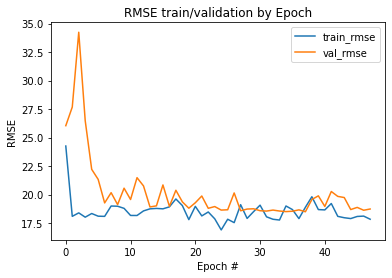

In [95]:
plt.figure()
plt.plot(current_model.history["rmse"], label="train_rmse")
plt.plot(current_model.history["val_rmse"], label="val_rmse")
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right");

In [85]:
x_2 = pd.read_csv('./train.csv')
x_2 = x_2[x_2['Pawpularity'] != 100]
y = x_2['Pawpularity']
x_2 = x_2.drop(['Pawpularity','Id'], axis=1)

x2_train,x2_test,y_train,y_test = train_test_split(x_2,y,test_size=0.33,random_state=7)

model = lgb.LGBMClassifier(learning_rate=0.01,max_depth=-5,random_state=7)

model.fit(x2_train,y_train,eval_set=[(x2_test,y_test),(x2_train,y_train)],
          verbose=20,eval_metric='rmse')

LightGBMError: Multiclass objective and metrics don't match

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

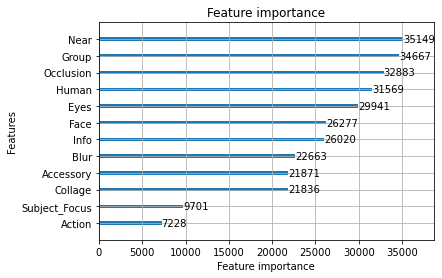

In [182]:
lgb.plot_importance(model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

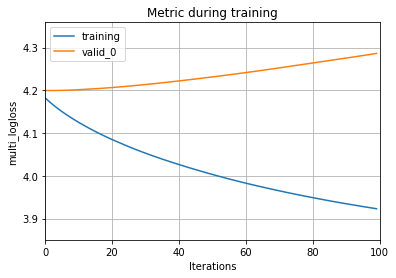

In [183]:
lgb.plot_metric(model)